# Mini-Project 2 Part 1 & Part 2 Notebook

# Part 1: Gradient Descent Experiments with Diabetes Dataset

In [1]:
# Ignoring overflow warnings
import warnings
warnings.filterwarnings('ignore')

# Importing Standard Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Importing Logistic Regression class
import full_batch as gd
import mini_batch as mgd

# Importing diabetes csv data
train = pd.read_csv('../../data/diabetes/diabetes_train.csv')
test = pd.read_csv('../../data/diabetes/diabetes_test.csv')
valid = pd.read_csv('../../data/diabetes/diabetes_val.csv')
all_data = pd.concat([train, test, valid], axis=0)

## Part 1.1: optimizing the maximum iterations and learning rate parameters for the data

In [2]:
def optimize(data, max_iter, learning_rate, pred_data,e=9.5e-3, mom=0):
    """
    Optimize a logisitic regression model's weights using gradient descent.
    This function makes it easier to test different combinations of the
    maximum iterations and learning rate parameters. 
    data:           [pd.DataFrame]  Training or Training+Validation data
    max_iter:       [int]           Maximum Iterations of gradient descent
    learning_rate:  [float]
    pred_data:      [pd.DataFrame]
    returns array of class probabilities
    """
    # preformance metric
    totAcc = []
    
    # Input data, features and binary labels column
    Xin = data.drop('Outcome',axis=1).to_numpy()
    Yin = data['Outcome'].to_numpy()
    # Data to run prediction on
    Xp = pred_data.drop('Outcome',axis=1).to_numpy()
    Yp = pred_data['Outcome'].to_numpy().ravel()
    
    # Iterate through the input parameters
    for l in learning_rate:
        for m in max_iter:
            prediction = []
            temp = []
            
            print(f'\n LEARNING RATE: {l}')
            model = gd.LogisticRegression(verbose=True, add_bias=True, learning_rate=l, max_iters=m,epsilon=e,momentum=mom)
            yh = model.fit(Xin,Yin).predict(Xp)
            temp.append(yh)
        
            # Decision Boundary
            for x in np.array(temp).ravel():
                if x < 0.5: prediction.append(0)
                else: prediction.append(1)
                    
            Acc = accuracy_score(Yp,np.array(prediction).ravel())
            totAcc.append(Acc)
            print("Accuracy Score:", Acc)
    
    print(f'Maximum Test Accuracy achieved: {max(totAcc)} for the combination {learning_rate} and {max_iter}')

In [ ]:
# Highest scoring result on test set and validation set
m = [1e6, 5e6]
l = [2e-4,9e-5]

print("RESULTS ON TEST SET: \n")
optimize(data=train, max_iter=m, learning_rate=l, pred_data=test)

print("RESULTS ON VALIDATION SET: \n")
optimize(data=train, max_iter=m, learning_rate=l, pred_data=valid)

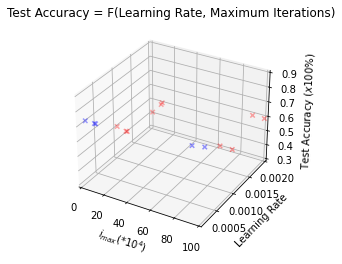

In [4]:
# Plot for test accuracy as a function of learning rates and maximum iterations

ax = plt.axes(projection='3d', title="Test Accuracy = F(Learning Rate, Maximum Iterations)")

m =   [1,1,1,
       9,9,9,
       10,10,10,
       90,90,90,
       100,100,100,
       900,900,900]

l =   [1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4,
       1e-3,2e-3,2e-4]

acc = [0.5147058823529411, 0.4117647058823529, 0.7205882352941176,
       0.5, 0.4852941176470588, 0.7205882352941176,
       0.5, 0.5, 0.7205882352941176,
       0.5882352941176471, 0.5882352941176471, 0.7647058823529411,
       0.5882352941176471, 0.5882352941176471, 0.7794117647058824,
       0.6176470588235294, 0.6176470588235294, 0.75
       ]

ax.text(0,0,10,"Red points accuracy < 0.6, Blue points accuracy > 0.6",fontsize=15)


ax.set_xlabel('$i_{max}(*10^{4}$)')
ax.set_ylabel('Learning Rate')
ax.set_zlabel('Test Accuracy ($x100\%$)')

ax.set(xlim=(0, 100), ylim=(0.0001, 0.002), zlim=(0.3,0.9))

# Boundary for accuracies
color = []
for x in acc:
    if x < 0.62: color.append('r')
    else: color.append('b')

ax.scatter(m, l, acc, marker='x', c=color)

## Part 1.1 Results

* Our base model preformed better than the Sklearn SGD logisitic classifier with a margin greater than 10%

* Decision Boundary is set at X=0.5: $$P(y=1|X) < 0.5 \rightarrow \hat{y}=0$$ $$P(y=1|X) \geq 0.5 \rightarrow \hat{y}= 1$$ 


* Best accuracy achieved on the test set was 77.9%, validation set with 77% at $\alpha = 2 * 10^{-4}$ and $i_{max} = 1 * 10^6$

* Output:

```
VALIDATION SET:

LEARNING RATE: 0.0002
1000000 Iterations
Norm of gradient: 0.013429351710347736
Accuracy Score: 0.77

TEST SET:

LEARNING RATE: 0.0002
1000000 Iterations
Norm of gradient: 0.013429351710347736
Accuracy Score: 0.7794117647058824

```

## Part 1.2 Mini-Batch Stochastic Gradient Descent & Convergence Rate

### Convergence Conditions
* For the purposes of this project and from observing the past results, convergence was determined to be the conditions where accuracy was maximized and the norm of the gradient minimized (or approaching zero steadily)
* There is some tolerance we found which was $\epsilon = 9.5*10^{-3}$
* At this particular epsilon, accuracy was maximized, but after it, overfitting started to take place even though the norm of the gradient was still approaching zero

In [4]:
def miniBatch(data, max_iter, alpha, pred_data, size, epoch=1, e=9.5e-4, mom=0):
    
    # preformance metric
    totAcc = []
    
    # Input data, features and binary labels column
    Xin = data.drop('Outcome',axis=1).to_numpy()
    Yin = data['Outcome'].to_numpy()
    # Data to run prediction on
    Xp = pred_data.drop('Outcome',axis=1).to_numpy()
    Yp = pred_data['Outcome'].to_numpy().ravel()
            
    print(f'\n LEARNING RATE: {alpha}, MAXIMUM ITERATIONS: {max_iter}')
    model = mgd.LogisticRegression(verbose=True,add_bias=True,learning_rate=alpha, max_iters=max_iter,
                                  epsilon=e, momentum=mom, batchSize=size, epochs=epoch)
    y = model.fit(Xin,Yin)

* Collapse the following output because it very extensive

In [12]:
sizes = [8,16,32,64,128,150,256]

for s in sizes:
    miniBatch(data=train, max_iter=1e6, alpha=2e-4, pred_data=valid, size=s, epoch=10, e=5.5e-3)


 LEARNING RATE: 0.0002, MAXIMUM ITERATIONS: 1000000.0
Epoch: 1
Convergence: 0 Iterations
Norm of gradient: inf
Batch Size: 8    TEST accuracy: 0.6323529411764706   VALIDATION accuracy: 0.61
Epoch: 2
Convergence: 19366 Iterations
Norm of gradient: 0.005499886341673841
Batch Size: 8    TEST accuracy: 0.6470588235294118   VALIDATION accuracy: 0.55
Epoch: 3
Convergence: 624790 Iterations
Norm of gradient: 0.005499994591432655
Batch Size: 8    TEST accuracy: 0.5147058823529411   VALIDATION accuracy: 0.45
Epoch: 4
Convergence: 944297 Iterations
Norm of gradient: 0.005499995251794343
Batch Size: 8    TEST accuracy: 0.5441176470588235   VALIDATION accuracy: 0.51
Epoch: 5
Convergence: 61409 Iterations
Norm of gradient: 0.0054999643749737296
Batch Size: 8    TEST accuracy: 0.45588235294117646   VALIDATION accuracy: 0.49
Epoch: 6
Convergence: 1000000 Iterations
Norm of gradient: 0.008410485460056486
Batch Size: 8    TEST accuracy: 0.6911764705882353   VALIDATION accuracy: 0.67
Epoch: 7
Convergen

Batch Size: 150    TEST accuracy: 0.6911764705882353   VALIDATION accuracy: 0.62
Epoch: 2
Convergence: 14832 Iterations
Norm of gradient: 0.00549980463074207
Batch Size: 150    TEST accuracy: 0.7205882352941176   VALIDATION accuracy: 0.64
Epoch: 3
Convergence: 23792 Iterations
Norm of gradient: 0.00549998199251851
Batch Size: 150    TEST accuracy: 0.6911764705882353   VALIDATION accuracy: 0.61
Epoch: 4
Convergence: 10749 Iterations
Norm of gradient: 0.005499134005465715
Batch Size: 150    TEST accuracy: 0.6911764705882353   VALIDATION accuracy: 0.6
Epoch: 5
Convergence: 9585 Iterations
Norm of gradient: 0.005499592526866533
Batch Size: 150    TEST accuracy: 0.6323529411764706   VALIDATION accuracy: 0.6
Epoch: 6
Convergence: 116754 Iterations
Norm of gradient: 0.005499993357043168
Batch Size: 150    TEST accuracy: 0.7058823529411765   VALIDATION accuracy: 0.59
Epoch: 7
Convergence: 186120 Iterations
Norm of gradient: 0.005499986553333298
Batch Size: 150    TEST accuracy: 0.7058823529411

## Part 1.3 Gradient Descent with Momentum

## Part 1.4 Momentum in small mini-batch and large mini-batch gradient descent

# Part 2: Text Classification with Fake News Dataset